In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectPercentile, SelectFromModel, mutual_info_classif, chi2, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization
import sklearn.metrics as skm
import pandas as pd
import numpy as np

data_train = pd.read_csv("../preprocessing/preprocesed_variables_train.csv")
important_variables = pd.read_csv("../preprocessing/important.csv")

X = data_train.drop(columns=['health', 'uniqueid'])
#X = X[important_variables['0']]
y = data_train['health']
id = data_train['uniqueid']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=20712124, stratify = y)

# Create correlation matrix
corr_matrix = X_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

X_train = X_train.drop(X_train[to_drop], axis=1)
X_test = X_test.drop(X_test[to_drop], axis=1)

In [3]:
def evaluate(model, X_test, y_actual):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    return (skm.log_loss(y_actual, y_pred_proba), skm.accuracy_score(y_actual, y_pred))

def pct_abs_diff(a, b):
    for ai, bi in zip(a, b):
        print(100*((ai - bi)/ai))

In [4]:
# feature selection based of l1 penalty using linear svc
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
temp_m = SelectFromModel(lsvc, prefit=True)
X_new = temp_m.transform(X_train)
X_new_test = temp_m.transform(X_test)

cols = temp_m.get_support(indices=True)
cols = X_train.columns[cols]
cols

E:\Anaconda\envs\tf_gpu\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
E:\Anaconda\envs\tf_gpu\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
E:\Anaconda\envs\tf_gpu\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Index(['year', 'x1', 'x2', 'x3', 'x6', 'x14', 'x19', 'x73', 'x138', 'x151',
       'x162', 'x164', 'x175', 'x227', 'x229', 'x230', 'x275', 'x285', 'x385',
       'x452', 'x453', 'x472', 'x497', 'x545', 'x546', 'x547', 'x595', 'x596',
       'x614', 'x615', 'x616', 'x617', 'x618', 'x620', 'x633', 'x639', 'x641',
       'x644', 'x650', 'x651', 'x655', 'x657', 'x661', 'x662', 'x664', 'x668',
       'x695', 'x718', 'x720', 'x754', 'x782', 'x785', 'x787', 'x843', 'x896',
       'x898', 'x901', 'x913', 'x919', 'x922', 'x929', 'x931', 'x934', 'x935',
       'x946', 'x948', 'x953', 'x960', 'x961', 'x975', 'x1036', 'x1039',
       'x1041', 'x1048', 'x1106', 'x1132', 'x1144', 'x1147', 'x1150', 'x1155',
       'x1157', 'x1158', 'x1159', 'x1166', 'x1167', 'x1176', 'x1177', 'x1178',
       'x1179', 'x1201', 'x1203'],
      dtype='object')

In [5]:
X_new = pd.DataFrame(X_new, columns = cols)
X_new_test = pd.DataFrame(X_new_test, columns = cols)

y_train = pd.DataFrame(y_train, columns=['health'])
y_test = pd.DataFrame(y_test, columns=['health'])

X_new.insert(0, 'health', y_train)
X_new_test.insert(0, 'health', y_test)
X_new.to_csv("TRAIN.csv", index = False)
X_new_test.to_csv("TRAIN_VALID.csv", index = False)

In [6]:
data_test = pd.read_csv("../preprocessing/preprocesed_variables_test.csv")
uniques = data_test['uniqueid']
data_test = data_test.drop(columns=['health', 'uniqueid'])

data_test = data_test.drop(data_test[to_drop], axis=1)
#data_test = temp_m.transform(data_test)
data_test = pd.DataFrame(data_test, columns = cols)

data_test.insert(0, 'uniqueid', uniques)
data_test.to_csv("TEST.csv", index=False)

In [115]:
X_train

,year,x1,x2,x3,x4,x5,x6,x7,x8,x14,...,x1176,x1177,x1178,x1179,x1180,x1185,x1201,x1202,x1203,x1204
11685,2013.0,0.75,0.25,0.75,0.50,0.0,0.0,0.444444,0.0,0.25,...,0.0,0.0,0.25,0.900,0.0,0.20,0.0,0.333333,0.333333,0.888889
8323,2011.0,0.50,0.25,0.25,0.00,0.0,0.0,0.222222,0.0,0.25,...,0.0,0.0,0.25,0.900,0.0,0.08,0.0,0.266667,0.833333,1.000000
8525,2011.0,0.25,0.25,0.50,0.25,0.0,0.0,0.555556,0.0,0.50,...,0.0,0.0,0.25,0.800,0.0,0.06,0.0,0.533333,0.166667,0.222222
5009,2007.0,0.75,0.75,0.75,0.75,0.0,0.0,0.666667,0.0,1.00,...,0.5,0.0,0.50,0.720,0.0,0.02,0.0,0.266667,0.833333,0.777778
1015,2005.0,1.00,0.50,0.50,0.25,0.0,0.0,0.444444,0.0,0.25,...,0.0,1.0,0.50,0.625,0.0,0.28,0.0,0.266667,0.833333,0.777778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7946,2009.0,0.25,0.75,0.75,0.50,1.0,1.0,0.444444,1.0,0.50,...,0.0,0.0,0.25,0.500,0.0,0.36,0.0,0.533333,0.166667,0.111111
9720,2011.0,0.50,0.25,0.25,0.50,0.0,0.0,0.555556,0.0,0.25,...,0.0,0.0,0.25,0.600,0.0,0.02,1.0,0.733333,0.833333,0.777778
11534,2013.0,0.50,0.75,0.50,0.50,0.0,0.0,0.222222,0.0,0.25,...,0.0,0.0,0.50,0.500,0.0,0.00,1.0,0.680000,1.000000,1.000000
14779,2017.0,0.00,0.25,0.50,0.25,0.0,0.0,0.555556,0.0,0.50,...,0.0,1.0,0.25,0.700,1.0,0.06,0.0,0.266667,0.333333,0.222222


In [7]:
from sklearn.metrics import make_scorer, accuracy_score, log_loss
from sklearn.model_selection import cross_val_score

#Bayesian optimization
def bayesian_optimization(function, parameters):
   n_iterations = 5
   gp_params = {"alpha": 1e-4}

   BO = BayesianOptimization(function, parameters)
   BO.maximize(n_iter=n_iterations, init_points=20)

   return BO.max

def rfc_optimization(cv_splits, X):
    def fn(n_estimators, max_depth, min_samples_split, min_samples_leaf):
        return cross_val_score(
               RandomForestClassifier(
                   n_estimators=int(max(n_estimators,10)),                                                               
                   max_depth=int(max(max_depth,1)),
                   min_samples_split=int(max(min_samples_split,2)),
                   min_samples_leaf=int(max(min_samples_leaf,1)), 
                   n_jobs=5,   
                   class_weight="balanced",
                   max_features='sqrt',
                   criterion='entropy'),  
               X=X, 
               y=y_train, 
               cv=cv_splits,
               scoring="neg_log_loss",
               n_jobs=5).mean()

    parameters = {"n_estimators": (400, 1500),
                  "max_depth": (50, 200),
                  "min_samples_split": (2, 6),
                  "min_samples_leaf": (1, 5)}
    
    return fn, parameters

In [102]:
# best param for no resampled
({'bootstrap': False,
  'criterion': 'entropy',
  'max_depth': 40,
  'max_features': 'sqrt',
  'min_samples_leaf': 2,
  'min_samples_split': 5,
  'n_estimators': 130},
 0.4642907427779966)

({'bootstrap': False,
  'criterion': 'entropy',
  'max_depth': 40,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 130},
 -0.8123411797949084)

({'n_estimators': 1400,
  'min_samples_split': 5,
  'min_samples_leaf': 2,
  'max_features': 'sqrt',
  'max_depth': None,
  'bootstrap': False},
 -1.216870811680116)

X_new

,health,year,x1,x2,x3,x14,x19,x162,x163,x164,...,x1159,x1166,x1167,x1176,x1177,x1178,x1179,x1201,x1203,x1204
0,1,2013.0,0.75,0.25,0.75,0.25,0.0,0.533333,0.50,0.666667,...,0.0,0.750,0.0,0.0,0.0,0.25,0.900,0.0,0.333333,0.888889
1,1,2011.0,0.50,0.25,0.25,0.25,0.0,1.000000,0.25,0.555556,...,0.0,0.500,0.0,0.0,0.0,0.25,0.900,0.0,0.833333,1.000000
2,2,2011.0,0.25,0.25,0.50,0.50,0.0,0.666667,0.50,0.555556,...,0.0,0.250,0.0,0.0,0.0,0.25,0.800,0.0,0.166667,0.222222
3,3,2007.0,0.75,0.75,0.75,1.00,0.1,0.333333,0.25,0.222222,...,1.0,0.000,1.0,0.5,0.0,0.50,0.685,0.0,0.833333,0.777778
4,2,2005.0,1.00,0.50,0.50,0.25,0.2,0.333333,0.25,0.522222,...,0.0,0.275,0.5,0.0,1.0,0.50,0.665,0.0,0.833333,0.777778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12173,4,2009.0,0.25,0.75,0.75,0.50,0.0,0.666667,0.25,0.111111,...,0.0,0.000,1.0,0.0,0.0,0.25,0.500,0.0,0.166667,0.111111
12174,3,2011.0,0.50,0.25,0.25,0.25,1.0,0.333333,0.50,0.444444,...,0.0,0.000,1.0,0.0,0.0,0.25,0.600,1.0,0.833333,0.777778
12175,3,2013.0,0.50,0.75,0.50,0.25,0.0,0.433333,0.25,0.777778,...,0.0,0.000,0.0,0.0,0.0,0.50,0.500,1.0,1.000000,1.000000
12176,2,2017.0,0.00,0.25,0.50,0.50,0.0,0.666667,0.50,0.666667,...,0.0,0.250,0.0,0.0,1.0,0.25,0.700,0.0,0.333333,0.222222


In [8]:
{'max_depth': 129.94178132407424,
 'min_samples_split': 6.278309435171526,
 'n_estimators': 831.2625515534467}
best_solution['params']

NameError: name 'best_solution' is not defined

In [9]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectPercentile, SelectFromModel, mutual_info_classif, chi2, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier

pipe = Pipeline([
    #('feature_selection', SelectPercentile(score_func=mutual_info_classif, percentile=10)),
    #('feature_selection', SelectFromModel(LinearSVC(C=0.01, penalty="l1", dual=False))),
    #('feature_selection', SelectFromModel(LinearSVC(C=0.02, penalty="l2", dual=False))),
    #('feature_selection', SelectFromModel(ExtraTreesClassifier(n_estimators=round(best_solution['params']['n_estimators'])))),
    #('feature_selection', SelectKBest(score_func=mutual_info_classif, k=50)),
    ('classification', RandomForestClassifier(
        # n_estimators=round(best_solution['params']['n_estimators']),
        # max_depth=round(best_solution['params']['max_depth']),
        # min_samples_split=round(best_solution['params']['min_samples_split']),
        # min_samples_leaf=round(best_solution['params']['min_samples_leaf']),
        n_estimators=round(124),
        max_depth=round(3),
        min_samples_split=round(5),
        min_samples_leaf=round(820),
        criterion='entropy',
        max_features='sqrt',
        n_jobs = -1
    ))
    # ('classification', RandomForestClassifier(
    #     criterion='entropy',
    #     max_features='sqrt',
    #     n_jobs = -1
    # ))
], verbose = True)
print("fitting")
pipe.fit(X_new.iloc[:,2:], y_train)
print("done fitting")
evaluate(pipe, X_new_test.iloc[:,2:], y_test)

fitting


E:\Anaconda\envs\tf_gpu\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[Pipeline] .... (step 1 of 1) Processing classification, total=   0.3s
done fitting


(1.2911771854008922, 0.44061302681992337)

In [22]:
X_new.iloc[:,1:]

,year,x1,x2,x14,x17,x19,x20,x76,x128,x162,...,x1040,x1048,x1055,x1147,x1158,x1167,x1176,x1177,x1179,x1201
0,2015.0,0.25,0.50,0.25,0.000000,0.00,1.0,1.0,0.0,0.666667,...,1.0,1.0,1.0,0.084746,1.0,0.0,0.5,0.0,0.500,1.0
1,2005.0,0.75,0.50,0.75,0.011111,0.00,1.0,1.0,0.0,0.333333,...,0.0,0.0,0.0,0.932203,0.0,0.1,0.0,0.0,0.635,0.0
2,2013.0,0.50,0.50,0.50,1.000000,1.00,0.0,0.0,0.0,0.466667,...,1.0,1.0,1.0,0.762712,1.0,1.0,0.5,0.0,0.700,1.0
3,2017.0,0.50,0.25,0.50,0.000000,0.00,1.0,0.0,1.0,0.666667,...,1.0,1.0,0.0,0.000000,1.0,0.0,0.0,1.0,0.800,0.0
4,2009.0,0.50,0.50,0.25,1.000000,0.00,1.0,1.0,0.0,0.666667,...,0.0,0.0,0.0,0.050847,1.0,0.0,0.0,1.0,0.700,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8899,2011.0,0.25,0.25,0.00,0.022222,0.00,0.0,0.0,0.0,0.666667,...,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,1.0,0.700,0.0
8900,2017.0,0.25,0.50,0.50,0.033333,0.00,1.0,0.0,0.0,0.000000,...,1.0,0.0,0.0,0.677966,1.0,1.0,0.0,1.0,0.600,1.0
8901,2009.0,0.50,0.50,0.50,0.167778,0.15,0.0,1.0,1.0,0.666667,...,0.0,0.0,0.0,0.932203,1.0,0.0,0.0,1.0,0.600,0.0
8902,2015.0,0.50,0.25,0.75,0.011111,0.00,1.0,1.0,0.0,0.666667,...,1.0,1.0,1.0,0.254237,0.0,1.0,0.0,1.0,0.600,1.0


In [21]:
data_test.iloc[:, :]

,uniqueid,year,x1,x2,x14,x17,x19,x20,x76,x128,...,x1040,x1048,x1055,x1147,x1158,x1167,x1176,x1177,x1179,x1201
0,20053998,2005.0,0.50,0.50,0.25,0.011111,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.779661,1.0,0.6,0.0,1.0,0.66,1.0
1,20053994,2005.0,1.00,0.75,1.00,0.000000,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.830508,1.0,0.4,0.0,1.0,0.50,1.0
2,20053979,2005.0,0.50,0.25,0.00,0.000000,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.728814,1.0,0.0,0.0,0.0,0.72,1.0
3,20053976,2005.0,1.00,0.50,0.00,0.013333,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.881356,0.0,0.4,0.0,1.0,0.52,1.0
4,20053964,2005.0,0.75,0.75,0.75,0.000000,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.559322,1.0,0.6,0.0,1.0,0.70,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7437,2019527,2019.0,0.50,0.25,1.00,1.000000,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.508475,1.0,0.0,0.0,1.0,0.80,1.0
7438,2019526,2019.0,0.25,0.25,0.50,0.022222,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,0.949153,1.0,0.0,0.0,1.0,0.90,0.0
7439,2019525,2019.0,0.00,0.00,0.00,0.033333,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.762712,1.0,0.0,0.0,1.0,0.90,0.0
7440,2019524,2019.0,0.00,0.00,0.00,0.455556,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.288136,1.0,0.0,0.0,1.0,0.80,0.0


In [24]:
# rf_cv = RandomForestClassifier(
#         n_estimators=round(best_solution['params']['n_estimators']),
#         max_depth=round(best_solution['params']['max_depth']),
#         min_samples_split=round(best_solution['params']['min_samples_split']),
#         criterion='entropy',
#         max_features='sqrt',
#         n_jobs = -1
# ).fit(X_new, y_train)


uniques
#data_test = data_test.drop(columns='uniqueid')
#data_test = data_test[important_variables['0']]

test_pred_proba = pipe.predict_proba(data_test.iloc[:, 2:])

preds = pd.DataFrame(test_pred_proba, columns=['p1','p2','p3','p4','p5'])
preds.insert(0, 'uniqueid', uniques)

preds.to_csv("rf_pred.csv", index = False)
#evaluate(pipe, X_new_test, y_test)

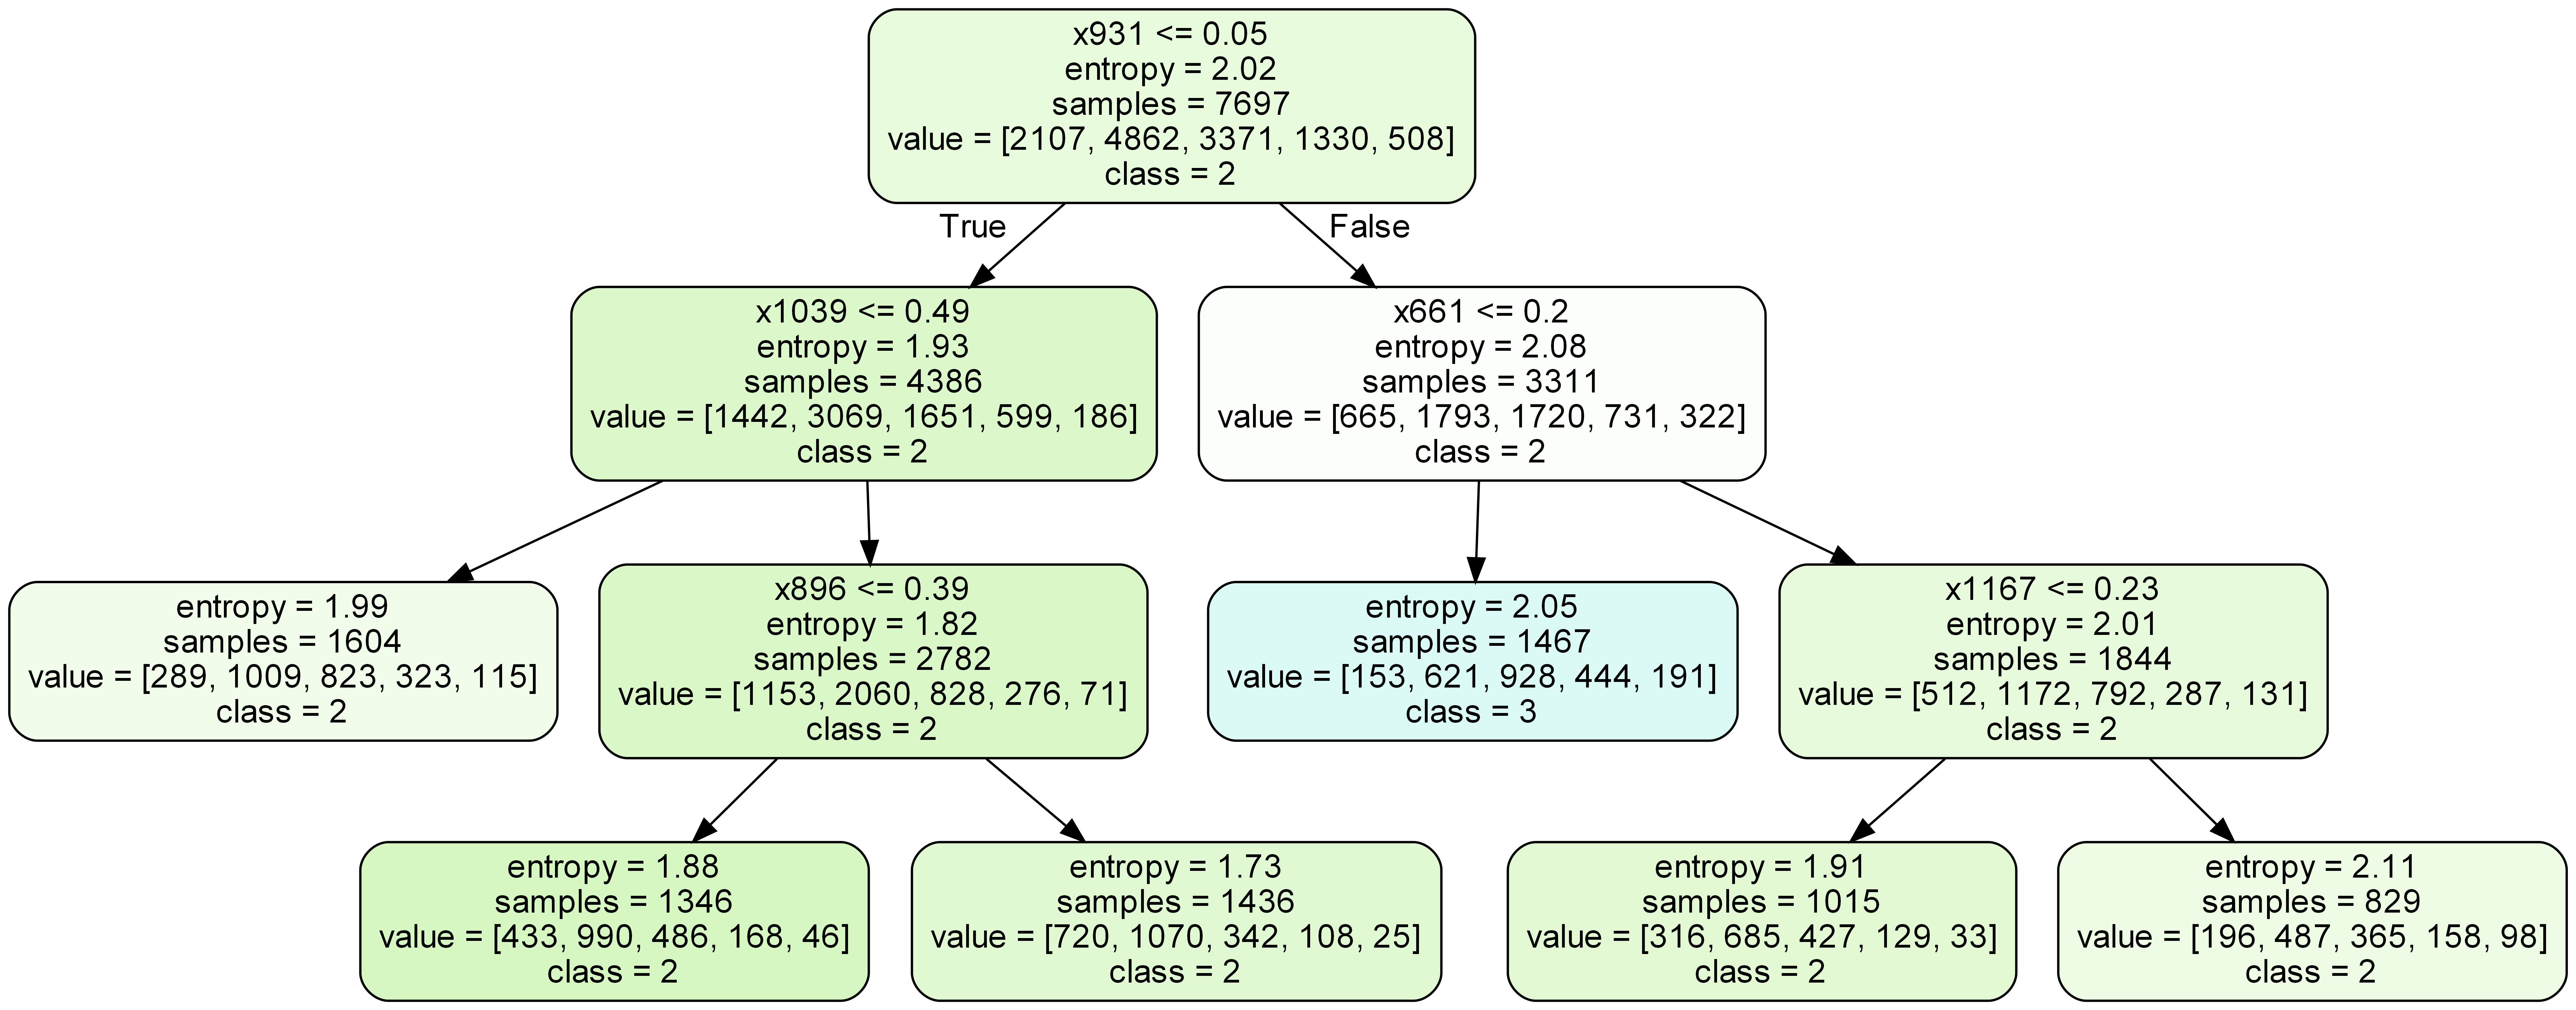

In [12]:
model = pipe['classification']
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X_new.iloc[:,2:].columns,
                class_names = ["1",'2','3','4','5'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

AttributeError: 'RandomForestClassifier' object has no attribute 'tree_'

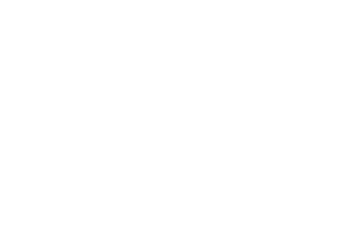

In [13]:
from sklearn import tree
tree.plot_tree(pipe['classification'])